# Object recognition with keras

<img src="https://media.giphy.com/media/l0MYxW1PyZl1qEA1O/giphy.gif" align="right" width="250" />

Hi again! Let's do some object recognition with keras! We'll make a CNN from the ground up, one that's specialized to **recognize hand drawn doodles**. "Like pictionary?" Yes exactly like pictionary!

We've seen the basics of how CNN's process visual data in [the previous section](./1.convolutional_neural_networks), we'll compose a net that accepts a picture you draw yourself and guess what's on it! This may not have that much practical use, but it serves as a nice **learning experience** on how neural nets work step by step before you tackle the challenges ahead!

We'll use part of google's generously documented ['quick, draw!' dataset](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/simplified) to train our model.

We're using the simplified dataset, but still, there are too many categories to download all of them! That's alright, **pick out two classes** and download them to your machine for use, you'll use those in this notebook for object recognition!


## Examining the data

Let's take a look at what we dragged out of google's database. For this exercise, I'll be using the **cat** and **dog** classes, but as stated before, you can choose your own classes!

In [1]:
!wget -N https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy -P ../assets/
!wget -N https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy -P ../assets/

--2021-04-02 10:48:43--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.213.176, 172.217.19.240, 216.58.215.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.213.176|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘../assets/dog.npy’ not modified on server. Omitting download.

--2021-04-02 10:48:43--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.74.240, 172.217.18.208, 216.58.206.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.74.240|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘../assets/cat.npy’ not modified on server. Omitting download.



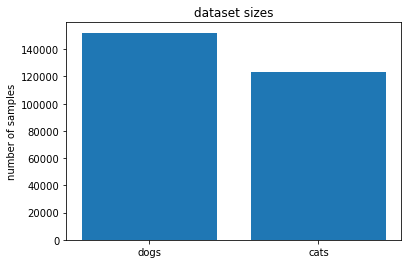

In [2]:
import numpy as np
from matplotlib import pyplot as plt
dogs = np.load("../assets/dog.npy")
cats = np.load("../assets/cat.npy")

plt.bar([0,1], [dogs.shape[0], cats.shape[0]])
plt.title('dataset sizes')
plt.xticks([0,1], ['dogs', 'cats'])
plt.ylabel('number of samples');

That's a lot of cats and dogs!

Google has been so kind to deliver us a **cleaned dataset**, the process of cleaning was as follows:

1. Align the drawing to the top-left corner, to have minimum values of 0.
2. Uniformly scale the drawing, to have a maximum value of 255.
3. Resample all strokes with a 1 pixel spacing.
4. Simplify all strokes using the Ramer–Douglas–Peucker algorithm with an epsilon value of 2.0.

This would have given them an image like the following.
![Cat Drawing (Image)](../assets/cat_drawing.png)

To get to an image like we had before, they had to transform this datatype from **vector format** to **raster format**! You might wonder why this step is necessary. Vector format retains all of the original information and is easy to store; no need to store all pixels, only 2 points for every line. BUT...convolutional neural networks want all those intermediate pixels as well! We want a **grid of pixels** to feed to our network so we can **convolve and pool**.

Fortunately, the `.npy` file format contains the pixel values of the cats and dogs in binary, so we do not need to clean them more.

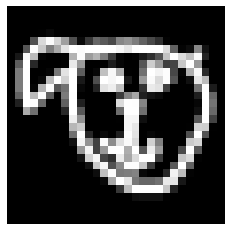

In [3]:
def plot_raster(image):
    plt.imshow(image, cmap="gray")
    plt.axis('off')

dog_sample = dogs[0].reshape(28,28)
plot_raster(dog_sample)

What a cute little doggy!

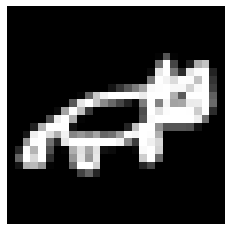

In [4]:
cat_sample = cats[1].reshape(28,28)
plot_raster(cat_sample)

There we go, the same kitty as above but in a raster format! When this is fed to a **CNN**, the input layer can accept this input as an **image** comprising as a 28 by 28 grid of **pixels** that are either activated or not. This way, our neural network can also **convolve** the image and **pool** the pixels. This would be a bit hard to do with the original **vector format**.

We have more than enough samples to work with, so let's take a nicely **balanced subset** of our data so we don't get bias in the final model.

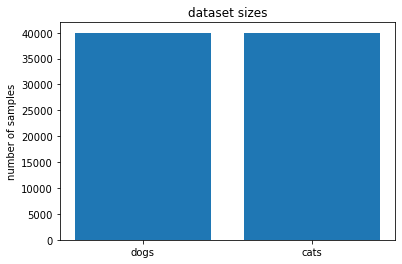

In [5]:
# 40000 samples is a nice balance to have enough data to have a nice
# accuracy, without training for too long

max_samples = 40000
preprocessed_cats = cats[:max_samples].reshape(-1,28,28)
preprocessed_dogs = dogs[:max_samples].reshape(-1,28,28)

# Normalizing
preprocessed_cats = preprocessed_cats/255
preprocessed_dogs = preprocessed_dogs/255

plt.bar([0,1], [preprocessed_dogs.shape[0], preprocessed_cats.shape[0]])
plt.title('dataset sizes')
plt.xticks([0,1], ['dogs', 'cats'])
plt.ylabel('number of samples');

Now, let's add the labels as well! Our neural network won't like **string values like 'cat' and 'dog**, but will want numeric representations instead. let's use **0 for cats, and 1 for dogs**. When you handle classifiers with more than two possible classes, don't forget the one-hot encoding format! Keras has the handy [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function) function for this. For this example though, it is not needed.

In [6]:
cat_labels = np.zeros((max_samples, 1))
dog_labels = np.ones((max_samples, 1))

labels = np.concatenate([cat_labels, dog_labels])
drawings = np.concatenate([preprocessed_cats, preprocessed_dogs])

# tensorflow wants a 4D tensor with (n_images, width, height, colour_depth)
print("Drawings shape before : ", drawings.shape)
drawings = np.expand_dims(drawings, axis=3)
print("Drawings shape after : ", drawings.shape)
print("Label shape : ", labels.shape)

Drawings shape before :  (80000, 28, 28)
Drawings shape after :  (80000, 28, 28, 1)
Label shape :  (80000, 1)


One final step: **separating our dataset into a train/val/test set**.

In [7]:
from sklearn.model_selection import train_test_split

train_val_drawings, test_drawings, train_val_labels, test_labels = train_test_split(
    drawings, 
    labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

train_drawings, val_drawings, train_labels, val_labels = train_test_split(
    train_val_drawings, 
    train_val_labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

print("train_drawings shape : ", train_drawings.shape)
print("val_drawings shape : ", val_drawings.shape)
print("test_drawings shape : ", test_drawings.shape)

print("train_labels shape : ", train_labels.shape)
print("val_labels shape : ", val_labels.shape)
print("test_labels shape : ", test_labels.shape)

train_drawings shape :  (51200, 28, 28, 1)
val_drawings shape :  (12800, 28, 28, 1)
test_drawings shape :  (16000, 28, 28, 1)
train_labels shape :  (51200, 1)
val_labels shape :  (12800, 1)
test_labels shape :  (16000, 1)


## Composing and evaluating the model

### Composing the most simple form

You've seen in [convolutional neural networks](./1.convolutional_neural_networks.ipynb) the different parts of a typical CNN and how they relate to each other. **keras** makes it easy for us to quickly compose a neural network.

Let's start with the **simplist of convolutional neural networks**: A convolutional layer, followed by a flattening layer and a regular 1D dense layer. Why is this the most simple form, you ask? Well, our neural network cannot consist of only a conv layer, since these **accept and output a 2D data structure**. If the output and input layer are the same, the outputs is a very hard to interpret **2D layer**. How does this relate to our defined classes; The **cat class** and **dog class**? It doesn't, it needs to be flattened into a binary output, since we have two classes in our model.

We will fix some basic parameters below. You can use these values directly, they have been tested by us to be good enough for this task

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# pixel width and height of our images
input_size = 28

# number of filters in the convnet layer
filters = 64

# conv net parameters
strides = (2, 2)
pool_size = (2,2)
kernel_size = (5, 5)

You know how `tf.keras` works now. You'll implement the model described above using the `Sequential` API.
You also get a model summary below to show the output shapes.
In this first example, we'll only modify the default `kernel_size`, `activation` (use ReLU) and `input_shape` of the convolutional layer. We also specify the number of convolutional filters, given by the `filters` variable. The other parameters are left at their default values.


Store the model in a `model` variable.

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(filters, kernel_size = kernel_size, activation='relu', input_shape=(input_size, input_size, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 73730     
Total params: 75,394
Trainable params: 75,394
Non-trainable params: 0
_________________________________________________________________


The model summary should look similar to the following:
![Keras model 1 summary](../assets/first_summary.png)



In Tensorflow, we have a bit more control over what we can do with the loss function than in PyTorch.
Indeed, in this case, we have the choice between 4 different losses, which depend on:
- whether we one-hot encode our labels
- whether we use a Softmax activation in the last layer

The next will show the 4 solutions.



- We can put a `SoftMax()` on the last layer, **NOT** one-hot encode the labels and use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)


- We can **NOT** put a `Softmax()` on the last layer, **NOT** one-hot encode the labels and use [`tf.nn.sparse_softmax_cross_entropy_with_logits`](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits). This is equivalent to the above loss with the argument `from_logits` set to `True` : `SparseCategoricalCrossentropy(from_logits=True)` because the default is `False`.


- We can put a `SoftMax()` on the last layer, and one-hot encode labels and use [`tf.keras.losses.CategoricalCrossentropy(from_logits=False)`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)


- We can **NOT** put a `SoftMax()` on the last layer, and one-hot encode labels and use `tf.keras.losses.CategoricalCrossentropy(from_logits=True)`


**Logits** is a confusing term and often abused in the deep learning community, as it can mean a lot of things. Here, logits are meant to describe the input to the Softmax layer, or generally any output from a neuron that has not been passed through an activation function.

Now is the time to train the model.

Use the Adam optimizer, one of the above mentioned loss functions loss and the accuracy as a metric.

Then fit the model for `6` epochs, and not forgetting to use the validation set.

Store the result of the fit in `history` variable.

In [10]:
model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
BATCH_SIZE = 64
EPOCHS = 6
# If you have a GPU, the following line allows us to speed up 
# the training by a great deal.
with tf.device('/GPU:0'): 
    history = model.fit(train_drawings, 
                        train_labels, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_data=(val_drawings, val_labels)
                       )

Epoch 1/6
800/800 [==============================] - 10s 10ms/step - loss: 0.4046 - accuracy: 0.8117 - val_loss: 0.3119 - val_accuracy: 0.8638
Epoch 2/6
800/800 [==============================] - 7s 9ms/step - loss: 0.2943 - accuracy: 0.8746 - val_loss: 0.3014 - val_accuracy: 0.8703
Epoch 3/6
800/800 [==============================] - 7s 8ms/step - loss: 0.2723 - accuracy: 0.8836 - val_loss: 0.2901 - val_accuracy: 0.8758
Epoch 4/6
800/800 [==============================] - 8s 10ms/step - loss: 0.2520 - accuracy: 0.8938 - val_loss: 0.2888 - val_accuracy: 0.8789
Epoch 5/6
800/800 [==============================] - 7s 9ms/step - loss: 0.2330 - accuracy: 0.9036 - val_loss: 0.2904 - val_accuracy: 0.8772
Epoch 6/6
800/800 [==============================] - 7s 9ms/step - loss: 0.2173 - accuracy: 0.9099 - val_loss: 0.2920 - val_accuracy: 0.8753


Now, let's evaluate out model by comparing our **test accuracy vs the training accuracy** with the matplotlib library.

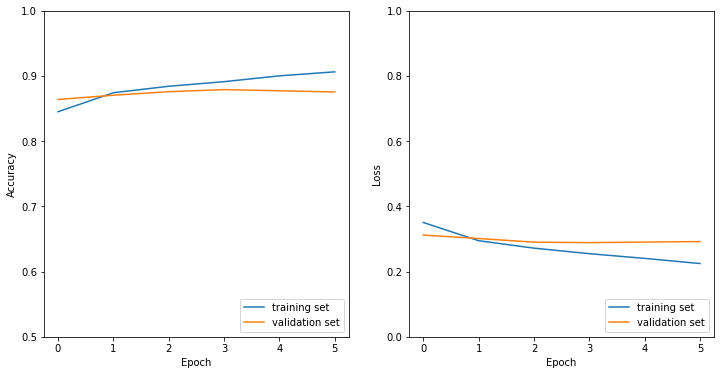

In [13]:
def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0.5, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 1])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [14]:
test_loss, test_acc = model.evaluate(test_drawings,  test_labels, verbose=2)

500/500 - 1s - loss: 0.2891 - accuracy: 0.8785


85% accuracy...Alright, not bad! But we can do better!
Notice that the validation loss does not increase anymore.

**Having only a single conv layer is maybe not enough to perfectly tell the difference between cat and dog doodles**. Why? Because right now, the neural network can just about make out if an image contains lines or not, which they both obviously do! Look at the image below:

![convnet_progression](./../assets/convnet_progression.png)

Each of these stages (from bottom to top) represent a convnet layer, and what it outputs. The bottom layer has 24 filters and seems to be able to make out the lines composing the image, but it's not connecting the dots so to speak. The features extracted by the first convnet layer are given to the next, and this layer connect these features into higher order features, and so on.

So we are still stuck in the first stage, we need to **extend our model**.

### Composing an extended model

Let's add another convnet layer! But in between these, we'll add a **pooling layer**. What's the purpose of this layer you ask? It has multiple purposes as seen in the last subchapter, but the main purpose here is **dimensionality reduction** to make it a bit easier on our model. Training the last model was already pretty challenging, and we don't need quantity, we need quality. Pooling (supposedly) redundant spatial information together is ofter done in CNN's for this reason.

Again, you know what to do. We will be modifying the same parameters as before, and you have the summary below again for the details. 

For the **pooling layer**, we will specify our own `strides` and `pool_size` parameters. Also specify `padding='same'`. 

Make sure to change those so that your summary matches the one provided.

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(filters, kernel_size = kernel_size, activation='relu', input_shape=(input_size, input_size, 1)))
model.add(layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding='same'))
model.add(layers.Conv2D(32, kernel_size = kernel_size, activation='relu', ))
model.add(layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation="softmax")) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 53,922
Trainable params: 53,922
Non-trainable params: 0
__________________________________________________

The model summary should look similar to the following:
![Keras model 2 summary](../assets/second_summary.png)

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

BATCH_SIZE = 64
EPOCHS = 10

with tf.device('/GPU:0'):
    history = model.fit(train_drawings, 
                        train_labels, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_data=(val_drawings, val_labels)
                       )

Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.4265 - accuracy: 0.7955 - val_loss: 0.2906 - val_accuracy: 0.8738
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2816 - accuracy: 0.8787 - val_loss: 0.2867 - val_accuracy: 0.8771
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2604 - accuracy: 0.8876 - val_loss: 0.2798 - val_accuracy: 0.8833
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2414 - accuracy: 0.8978 - val_loss: 0.2599 - val_accuracy: 0.8925
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2218 - accuracy: 0.9072 - val_loss: 0.2571 - val_accuracy: 0.8904
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2142 - accuracy: 0.9101 - val_loss: 0.2653 - val_accuracy: 0.8883
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1988 - accuracy: 0.9187 - val_loss: 0.2783 - val_accuracy: 0.8893
Epoc

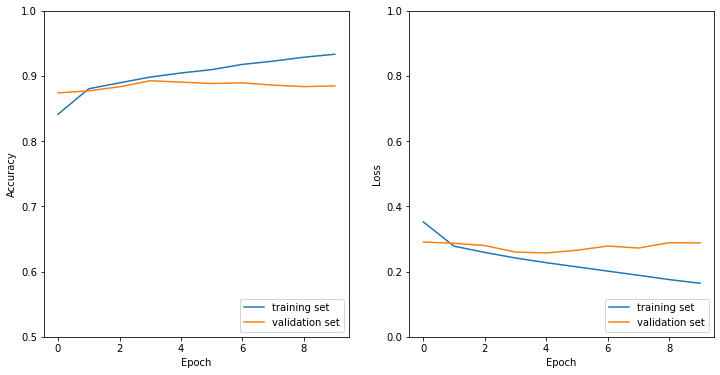

In [17]:
plot_history(history)

In [18]:
_ = model.evaluate(test_drawings,  test_labels, verbose=2)

500/500 - 1s - loss: 0.2863 - accuracy: 0.8829


88% ! YEAH, we added 3% to our accuracy! Right now, our model is still lacking something vital: **regular dense layers**! 

Adding these layers is a nice way to finally put the extracted features together and make nonlinear connections between them! Like "aha, sharp ear features + a triangle nose means a cat, probably >.>!".

We will also add some **Dropout** layers to reduce overfitting.


### Further extending the model with dense layers
Last model, like said above, we're adding `Dense` layers at the end and `Dropout` layers between the convolutional layers and the pooling layers. Remember that we are still modifying the same parameters for the **convolutional layer** and for the **pooling layer** as the two other models.

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(filters, kernel_size = kernel_size, activation='relu', input_shape=(input_size, input_size, 1)))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D(pool_size= pool_size, strides=strides, padding='same'))
model.add(layers.Conv2D(32, kernel_size = kernel_size, activation='relu', ))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D(pool_size = pool_size, strides=strides, padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

The model summary should look similar to the following:
![Keras model 3 summary](../assets/third_summary.png)

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

BATCH_SIZE = 64
EPOCHS = 10

with tf.device('/GPU:0'):
    history = model.fit(train_drawings, 
                        train_labels, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_data=(val_drawings, val_labels)
                       )

Epoch 1/10
800/800 [==============================] - 12s 15ms/step - loss: 0.4461 - accuracy: 0.7800 - val_loss: 0.3839 - val_accuracy: 0.8737
Epoch 2/10
800/800 [==============================] - 11s 13ms/step - loss: 0.3039 - accuracy: 0.8661 - val_loss: 0.3252 - val_accuracy: 0.8802
Epoch 3/10
800/800 [==============================] - 10s 13ms/step - loss: 0.2837 - accuracy: 0.8771 - val_loss: 0.3246 - val_accuracy: 0.8865
Epoch 4/10
800/800 [==============================] - 10s 13ms/step - loss: 0.2706 - accuracy: 0.8839 - val_loss: 0.3028 - val_accuracy: 0.8856
Epoch 5/10
800/800 [==============================] - 10s 13ms/step - loss: 0.2616 - accuracy: 0.8873 - val_loss: 0.2895 - val_accuracy: 0.8927
Epoch 6/10
800/800 [==============================] - 10s 13ms/step - loss: 0.2459 - accuracy: 0.8952 - val_loss: 0.2886 - val_accuracy: 0.8973
Epoch 7/10
800/800 [==============================] - 10s 13ms/step - loss: 0.2437 - accuracy: 0.8973 - val_loss: 0.2889 - val_accuracy:

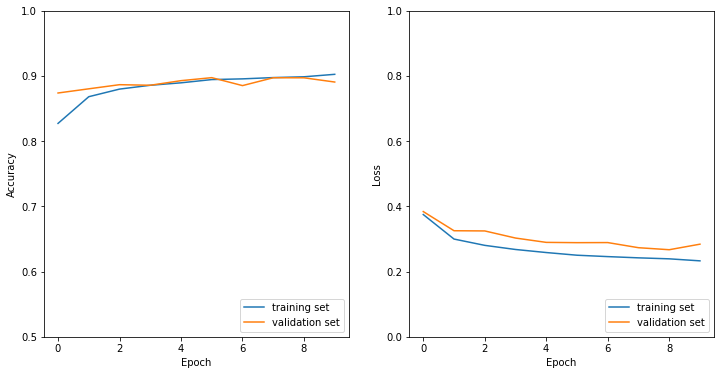

In [21]:
plot_history(history)

In [22]:
_ = model.evaluate(test_drawings,  test_labels, verbose=2)

500/500 - 1s - loss: 0.2768 - accuracy: 0.8959


~89% accuracy ?! Now we're cookin'! This is starting to look good! There are a few ways to combat overfitting in a model as you already know. One of them is to **decrease the DOF's of the model**, another neat method often used in CNN's is **adding dropout layers**.

"Dropout layers?! I'm no quitter!". Don't worry, these are conceptually easy to understand: These **deactivate a fraction of the neurons of the preceeding layers at random** to encourage robustness on the overall layer. Deactivating them at random avoids the reliance on specific nodes and disallows the network to overly fit to the training set.

This method isn't perfect, and it needs a decently sized network, which may not be the case here, so it might not be necessary here.

Read more about dropout [here](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/).

Congratulations! You created your first convolutional neural networks from scratch, and were able to get a pretty good accuracy with a small network.

![Well done (GIF)](https://media.giphy.com/media/d31w24psGYeekCZy/giphy.gif)

## Testing the model

The following is a piece of code designed to take inputs from the user to generate a drawing from. **This code is very case specific and there is no need for you to learn the tkinter library for computer vision**. So just enjoy the result and continue on to the [next notebook](./4.object_recognition_with_pytorch.ipynb) after you're done playing around.

In [23]:
class LineDrawer:
    
    def __init__(self, canvas, input_size, output_size = 64, brush_size = 3, line_colour = "#476042"):
        self.canvas = canvas
        self.drawing = np.zeros((output_size, output_size))
        self.mouse_is_clicked = False
        self.brush_size = brush_size
        self.line_colour = line_colour
        self.scale_factor = float(output_size)/float(input_size)

    def on_motion(self, event):
        if not self.mouse_is_clicked:
            return
        x1, y1 = (event.x - self.brush_size), (event.y - self.brush_size)
        x2, y2 = (event.x + self.brush_size), (event.y + self.brush_size)
        self.canvas.create_oval(x1, y1, x2, y2, fill=self.line_colour)
        self.drawing[round(event.y*self.scale_factor), round(event.x*self.scale_factor)] = 255

    def on_down_press(self, event):
        self.mouse_is_clicked = True

    def on_release(self, event):
        self.mouse_is_clicked = False


In [24]:
import tkinter as tk

# run this cell to get a drawing interface! Just close it once you are done
gui = tk.Tk()
canvas_size = 512
canvas = tk.Canvas(gui, width=canvas_size, height=canvas_size)
line_drawer = LineDrawer(canvas, canvas_size, 28)
canvas.bind('<Motion>', line_drawer.on_motion)
canvas.bind('<Button-1>', line_drawer.on_down_press)
canvas.bind('<ButtonRelease-1>', line_drawer.on_release)
canvas.pack()
gui.mainloop()

In [ ]:
plot_raster(line_drawer.drawing)

In [ ]:
drawing_input = line_drawer.drawing.reshape(1, 28, 28, 1)
prediction = model.predict(drawing_input)
print(f"Predictions : {prediction[0][0] * 100 :.2f}% cat, {prediction[0][1] * 100 :.2f}% dog ")

In [27]:
# run this cell to get a drawing interface!
gui = tk.Tk()
canvas_size = 512
canvas = tk.Canvas(gui, width=canvas_size, height=canvas_size)
second_line_drawer = LineDrawer(canvas, canvas_size, 28)
canvas.bind('<Motion>', second_line_drawer.on_motion)
canvas.bind('<Button-1>', second_line_drawer.on_down_press)
canvas.bind('<ButtonRelease-1>', second_line_drawer.on_release)
canvas.pack()
gui.mainloop()

In [ ]:
plot_raster(second_line_drawer.drawing)

In [ ]:
drawing_input = second_line_drawer.drawing.reshape(1, 28, 28, 1)
prediction = model.predict(drawing_input)
print(f"Predictions : {prediction[0][0] * 100 :.2f}% cat, {prediction[0][1] * 100 :.2f}% dog ")